CSC529 Final project
Lan Nguyen

In [31]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [50]:
from google.colab import files

uploaded = files.upload()

Saving example.jpg to example (1).jpg


In [37]:
DIGITS_SEGMENT = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

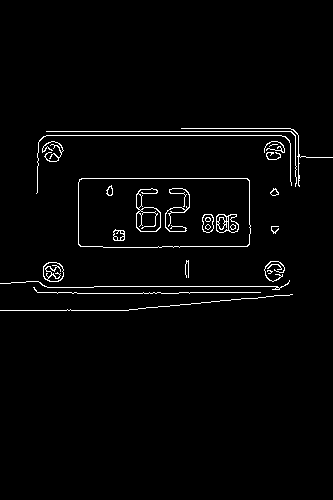

In [4]:
#Load the image
image = cv2.imread("example.jpg")

#Resize image
image = imutils.resize(image, height=500)

#Convert image into gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Apply filter to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#Apply Canny edge detector
edged = cv2.Canny(blurred, 50, 200, 255)

cv2_imshow(edged)

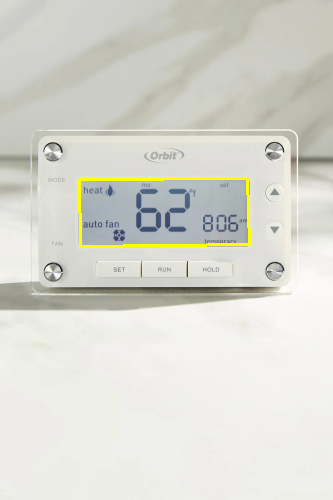

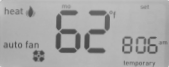

In [28]:
contours_ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ = imutils.grab_contours(contours_)
contours_ = sorted(contours_, key=cv2.contourArea, reverse=True)
desired_contours = None

#Iterate each contours in the image
for c in contours_:

	#Approximate the contour
	approx = cv2.approxPolyDP(c, 0.02 * cv2.arcLength(c, True), True)

	if len(approx) == 4:
		desired_contours = approx
		break

#Draw the contour
draw = cv2.drawContours(image, [desired_contours], -1, (0, 255, 255), 2)

#Extract the contour
LCD = four_point_transform(gray, desired_contours.reshape(4, 2))

cv2_imshow(draw)
cv2_imshow(LCD)

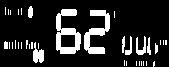

In [12]:
#Threshold the LCD then apply series of morphology operation to clean the threshold
thresh = cv2.threshold(LCD, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 3))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh = cv2.dilate(thresh, kernel2)

cv2_imshow(thresh)

In [19]:

contours_digit = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
contours_digit = imutils.grab_contours(contours_digit)


desired_contours_digit = []

for c in contours_digit:

  (x, y, w, h) = cv2.boundingRect(c)

  if w >= 15 and (h >= 30 and h <= 60):
    desired_contours_digit.append(c)
    roi = thresh[y:y + h, x:x + w]
    print("")
    cv2_imshow(roi)

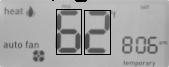

Digits found:  [6, 2]


In [49]:
desired_contours_digit = contours.sort_contours(desired_contours_digit,	method="left-to-right")[0]
digits = []

for c in desired_contours_digit:

  (x, y, w, h) = cv2.boundingRect(c)
  roi = thresh[y:y + h, x:x + w]

  #Identify the length and width of 7 segments
  (roiH, roiW) = roi.shape
  (segment_width, segment_height) = (int(roiW * 0.25), int(roiH * 0.15))
  segment_height_center = int(roiH * 0.05)
  
  
  segments = [
  ((0, 0), (w, segment_height)),  # top
  ((0, 0), (segment_width, h // 2)), # top-left
  ((w - segment_width, 0), (w, h // 2)), # top-right
  ((0, (h // 2) - segment_height_center) , (w, (h // 2) + segment_height_center)), # center
  ((0, h // 2), (segment_width, h)), # bottom-left
  ((w - segment_width, h // 2), (w, h)), # bottom-right
  ((0, h - segment_height), (w, h)) # bottom
  ]

  active = [0] * len(segments)
  for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
    segROI = roi[yA:yB, xA:xB]
    total = cv2.countNonZero(segROI)
    area = (xB - xA) * (yB - yA)
    if total / float(area) > 0.5:
      active[i]= 1


# 
  digit = DIGITS_SEGMENT[tuple(active)]
  digits.append(digit)
  cv2.rectangle(LCD, (x, y), (x + w, y + h), (0, 255, 0), 1)
  cv2.putText(LCD, str(digit), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2_imshow(LCD)
print("Digits found: ",digits)
